<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install --upgrade tensorflow_hub

  Using cached tensorflow_hub-0.11.0-py2.py3-none-any.whl (107 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Users\istra\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [13]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
import sklearn
from tensorflow.keras import layers
from sklearn.utils import class_weight
###############
import tensorflow_hub as hub

Checking our images

In [14]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers2"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*.jpg')))
print(image_count)

43390


Checking a childrens book

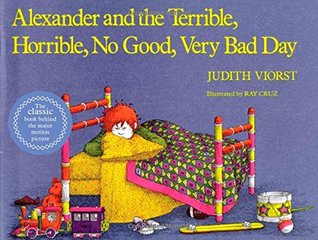

In [3]:
children = list(path.glob('Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [15]:
batch_size =32
img_height = 150
img_width =100
list_ds = tf.data.Dataset.list_files(str(path_s+"\*/*.jp*"),shuffle=False)
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Fantasy\\632.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Biography\\53712.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Young Adult\\52151.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Historical\\39613.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Romance\\23106.jpg'


In [16]:
class_names = np.array(sorted([item.name for item in path.glob('*') if os.path.isdir(item)]))
print(class_names)

['Biography' 'Childrens' 'Fantasy' 'Historical' 'Horror' 'Mystery & Crime'
 'Poetry' 'Politics & History' 'Religion & Philosophy' 'Romance'
 'Science Fiction' 'Sequential Art' 'Young Adult']


In [17]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

34712
8678


In [18]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  
  return tf.argmax(one_hot)

In [19]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [21]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
         
    return img,label


In [22]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Image shape:  (150, 100, 3)
Label:  5


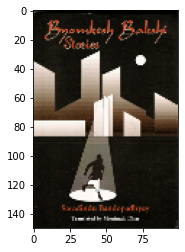

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image.numpy().astype("uint8"))

In [23]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000, reshuffle_each_iteration=False)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

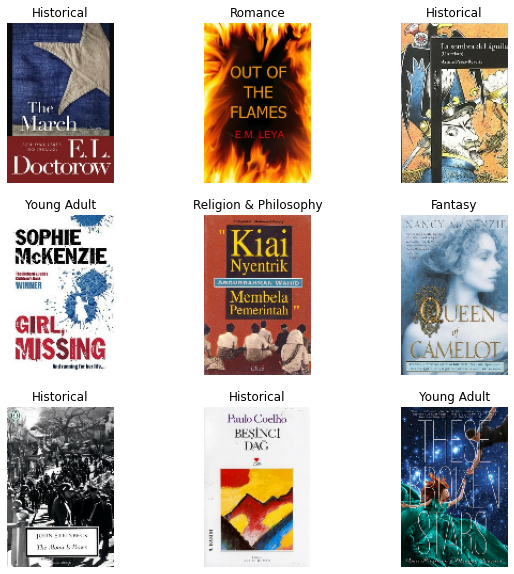

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [24]:
feature_extractor_model ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(150, 100, 3), trainable=False)

In [25]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  feature_extractor_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
 753/1085 [===================>..........] - ETA: 3:14 - loss: 2.5964 - accuracy: 0.1340

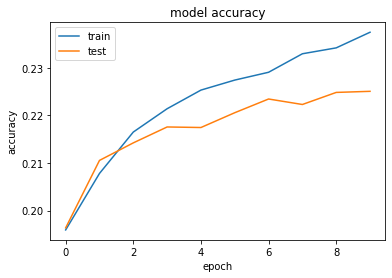

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in val_ds]

In [ ]:
validation_classes = np.concatenate(vclasses).ravel()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

In [ ]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        scores.append([dict_c.get(v),score])
    scores_df = pd.DataFrame(scores,columns=["genre","score"])
    meanscore =np.round(scores_df["score"].mean(),3)
    print("The average score is %s" %meanscore)
    return scores_df.groupby("genre").mean("score")

In [ ]:
prediction_score(validation_classes,predictions)